In [5]:
from scipy.spatial import distance
from sklearn import datasets, svm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def least_confident_sampling(proba):
    """Input must be of shape (n_samples, n_classes=2)"""
    cls = proba.max(axis=1)
    least_confident = cls.argmin()
    return least_confident

def id_strat(proba):
    inf_dens = np.zeros((pool.shape[0],))
    for i in range(pool.shape[0]):
        target = pool[i,:]
        tmp_pool = np.delete(pool, i, axis=0)
        inf_dens[i] = information_density(target, tmp_pool)
    
    cls = proba.max(axis=1) * inf_dens
    
    return cls.argmin()
    

def information_density(target, pool):    
    return np.sum(np.linalg.norm(np.tile(target, (pool.shape[0], 1)) - pool)) / pool.shape[0]
    

In [50]:
n_samples = 400
seed = 2
np.random.seed(seed)
centers = np.array([[2,1], [-2,-1]])
stds = np.array([[1,1],[1,1]])

In [51]:
blobs = datasets.make_blobs(n_samples, centers=centers, cluster_std=stds, random_state=seed)
pool = blobs[0]
target = blobs[1]

0.9925
214 [-0.08739932 -1.0452632 ] 1
(391, 2) (391,)
360 [0.20656441 0.15825263] 0
(390, 2) (390,)
163 [ 0.60369967 -0.06408385] 1
(389, 2) (389,)
164 [0.34779971 0.32433821] 0
(388, 2) (388,)
242 [-0.91114153  0.33531175] 1
(387, 2) (387,)
119 [-0.04032305  1.04625552] 0
(386, 2) (386,)
RESULT:


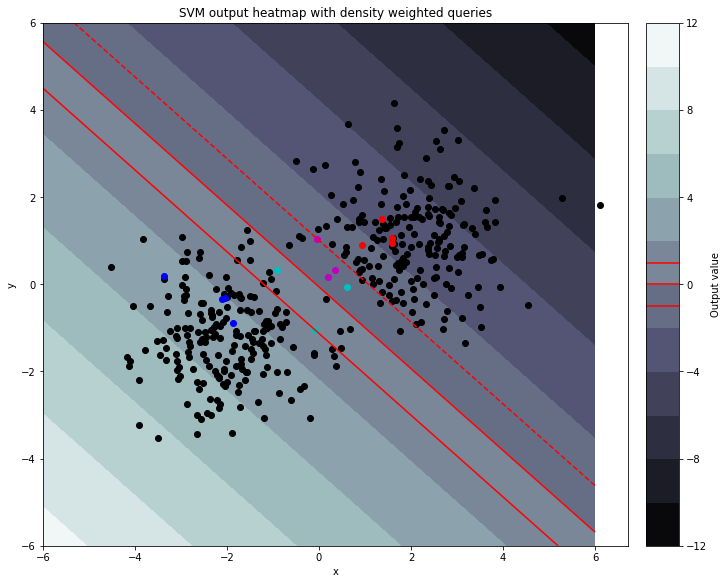

Accuracy with the whole dataset: 0.9925
Accuracy with the active training: 0.9948186528497409


In [52]:
# 2. train clf on full data set

clf_ref = svm.SVC(C=1, kernel='rbf', probability=False)
clf_ref.fit(pool, target)
acc_ref = accuracy_score(target,clf_ref.predict(pool), normalize=True)
print(acc_ref)

# 3. Randomly choose few initial samples

n_samples_init = 8
samples_init_idx = np.random.choice(np.arange(n_samples), size=n_samples_init, )
train_set = pool[samples_init_idx,:]
train_lab = target[samples_init_idx]
lab_0_idx = train_lab == 0
lab_1_idx = train_lab == 1
initial_label_0 = lab_0_idx
initial_label_1 = lab_1_idx
initial_samples = train_set

mask = np.ones((n_samples,)).astype(np.bool)

for i in samples_init_idx:
    mask[i] = False

pool = pool[mask,:] #removing the now labeled samples
target= target[mask] #Idem

# 4. Train 

clf = svm.SVC(C=1, kernel='linear', probability=True)
clf.fit(train_set, train_lab)
acc = accuracy_score(target, clf.predict(pool), normalize=True)
#sampling_strat = least_confident_sampling
sampling_strat = id_strat

while acc_ref-.0001 >= acc:
    # Selecting a new sample
    new_sample_idx = sampling_strat(clf.predict_proba(pool))
    new_sample = pool[new_sample_idx,:]
    new_label = target[new_sample_idx]
    print(new_sample_idx, new_sample, new_label)
    # Adding new sample to training set
    #print(train_set)
    #print(new_sample)
    #print(np.append(train_set, np.array([new_sample]), axis=0))
    tmp_set = np.append(train_set, np.array([new_sample]), axis=0)
    tmp_lab = np.append(train_lab, new_label)
    del(train_set); del(train_lab)
    train_set = tmp_set
    train_lab = tmp_lab
    del(tmp_set); del(tmp_lab)
    lab_0_idx = train_lab == 0
    lab_1_idx = train_lab == 1
    #print(train_set.shape, train_lab.shape)
    # Removing new sample from the pool
    mask = np.ones(pool.shape[0]).astype(np.bool)
    mask[new_sample_idx] = False
    pool = pool[mask,:]
    target = target[mask]
    print(pool.shape, target.shape)
    clf.fit(train_set, train_lab)
    acc = accuracy_score(target, clf.predict(pool), normalize=True)
    """
    plt.figure()
    plt.scatter(pool[:,0], pool[:,1], c='k')
    #plt.scatter(pool[new_sample_idx,0], pool[new_sample_idx,1], c='c')
    plt.scatter(train_set[lab_0_idx, 0], train_set[lab_0_idx, 1], c='b')
    plt.scatter(train_set[lab_1_idx, 0], train_set[lab_1_idx, 1], c='r')
    plt.show()
    """


print("RESULT:")
queries = train_set[n_samples_init:,:]
queries_l = train_lab[n_samples_init:]
queries_l_0 = queries_l == 0
queries_l_1 = queries_l == 1




BX = 6
origin = 'lower'
nbs = 100
delta = (2*BX)/(nbs-1)
_x = _y = np.arange(-BX, BX + .0001, delta)
_X, _Y = np.meshgrid(_x, _y)
Xr = np.reshape(_X, (nbs*nbs, 1))
Yr = np.reshape(_Y, (nbs*nbs, 1))

Xmap = np.concatenate((Xr, Yr), axis=1)
Ymapr = clf.decision_function(Xmap)
Ymap = np.reshape(Ymapr, (nbs, nbs))

fig1, ax1 = plt.subplots(constrained_layout=True, figsize=(10,8))
CS = ax1.contourf(_X, _Y, Ymap, 10, cmap=plt.cm.bone, origin=origin)
ax1.set_title('SVM output heatmap with density weighted queries')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

CS2 = ax1.contour(CS, levels=(-1,0,1), colors='r', origin=origin)

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Output value')

cbar.add_lines(CS2)

ax1.scatter(pool[:,0], pool[:,1], c='k')
ax1.scatter(initial_samples[initial_label_0,0], initial_samples[initial_label_0,1], c='r')
ax1.scatter(initial_samples[initial_label_1,0], initial_samples[initial_label_1,1], c='b')
ax1.scatter(queries[queries_l_0,0], queries[queries_l_0,1], c='m')
ax1.scatter(queries[queries_l_1,0], queries[queries_l_1,1], c='c')

plt.show()


print("Accuracy with the whole dataset:", acc_ref)
print("Accuracy with the active training:", acc)

0.9925
214 [-0.08739932 -1.0452632 ] 1
(391, 2) (391,)
97 [ 3.1735315  -1.34360319] 0
(390, 2) (390,)
215 [-0.65944946  0.90854738] 0
(389, 2) (389,)
291 [-1.08277952  0.2758269 ] 1
(388, 2) (388,)
357 [0.20656441 0.15825263] 0
(387, 2) (387,)
23 [-1.50596413  0.54627765] 1
(386, 2) (386,)
148 [ 0.68243273 -1.02559359] 0
(385, 2) (385,)
16 [ 0.38048446 -1.87558133] 1
(384, 2) (384,)
256 [ 0.16246241 -0.34244875] 1
(383, 2) (383,)
RESULT:


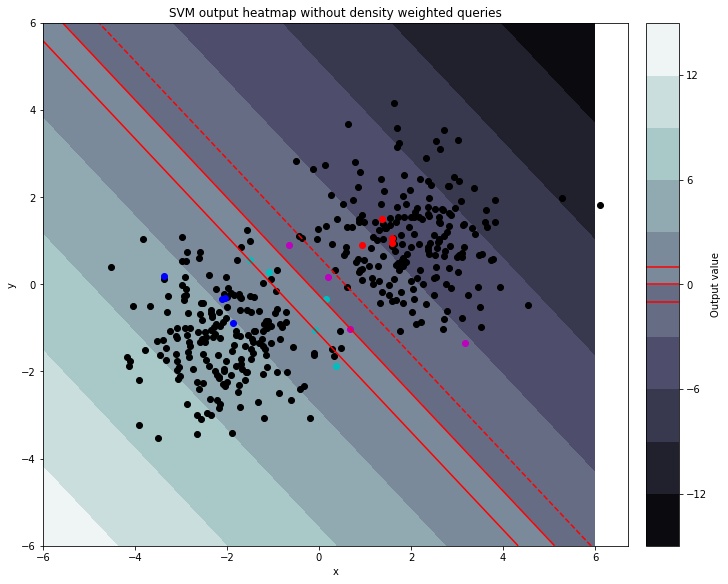

Accuracy with the whole dataset: 0.9925
Accuracy with the active training: 0.9947780678851175


In [53]:
n_samples = 400
seed = 2
np.random.seed(seed)
centers = np.array([[2,1], [-2,-1]])
stds = np.array([[1,1],[1,1]])

blobs = datasets.make_blobs(n_samples, centers=centers, cluster_std=stds, random_state=seed)
pool = blobs[0]
target = blobs[1]

# 2. train clf on full data set

clf_ref = svm.SVC(C=1, kernel='rbf', probability=False)
clf_ref.fit(pool, target)
acc_ref = accuracy_score(target,clf_ref.predict(pool), normalize=True)
print(acc_ref)

# 3. Randomly choose few initial samples

n_samples_init = 8
samples_init_idx = np.random.choice(np.arange(n_samples), size=n_samples_init, )
train_set = pool[samples_init_idx,:]
train_lab = target[samples_init_idx]
lab_0_idx = train_lab == 0
lab_1_idx = train_lab == 1
initial_label_0 = lab_0_idx
initial_label_1 = lab_1_idx
initial_samples = train_set

mask = np.ones((n_samples,)).astype(np.bool)

for i in samples_init_idx:
    mask[i] = False

pool = pool[mask,:] #removing the now labeled samples
target= target[mask] #Idem

# 4. Train 

clf = svm.SVC(C=1, kernel='linear', probability=True)
clf.fit(train_set, train_lab)
acc = accuracy_score(target, clf.predict(pool), normalize=True)
#sampling_strat = least_confident_sampling
sampling_strat = least_confident_sampling

while acc_ref-.0001 >= acc:
    # Selecting a new sample
    new_sample_idx = sampling_strat(clf.predict_proba(pool))
    new_sample = pool[new_sample_idx,:]
    new_label = target[new_sample_idx]
    print(new_sample_idx, new_sample, new_label)
    # Adding new sample to training set
    #print(train_set)
    #print(new_sample)
    #print(np.append(train_set, np.array([new_sample]), axis=0))
    tmp_set = np.append(train_set, np.array([new_sample]), axis=0)
    tmp_lab = np.append(train_lab, new_label)
    del(train_set); del(train_lab)
    train_set = tmp_set
    train_lab = tmp_lab
    del(tmp_set); del(tmp_lab)
    lab_0_idx = train_lab == 0
    lab_1_idx = train_lab == 1
    #print(train_set.shape, train_lab.shape)
    # Removing new sample from the pool
    mask = np.ones(pool.shape[0]).astype(np.bool)
    mask[new_sample_idx] = False
    pool = pool[mask,:]
    target = target[mask]
    print(pool.shape, target.shape)
    clf.fit(train_set, train_lab)
    acc = accuracy_score(target, clf.predict(pool), normalize=True)
    """
    plt.figure()
    plt.scatter(pool[:,0], pool[:,1], c='k')
    #plt.scatter(pool[new_sample_idx,0], pool[new_sample_idx,1], c='c')
    plt.scatter(train_set[lab_0_idx, 0], train_set[lab_0_idx, 1], c='b')
    plt.scatter(train_set[lab_1_idx, 0], train_set[lab_1_idx, 1], c='r')
    plt.show()
    """


print("RESULT:")
queries = train_set[n_samples_init:,:]
queries_l = train_lab[n_samples_init:]
queries_l_0 = queries_l == 0
queries_l_1 = queries_l == 1




BX = 6
origin = 'lower'
nbs = 100
delta = (2*BX)/(nbs-1)
_x = _y = np.arange(-BX, BX + .0001, delta)
_X, _Y = np.meshgrid(_x, _y)
Xr = np.reshape(_X, (nbs*nbs, 1))
Yr = np.reshape(_Y, (nbs*nbs, 1))

Xmap = np.concatenate((Xr, Yr), axis=1)
Ymapr = clf.decision_function(Xmap)
Ymap = np.reshape(Ymapr, (nbs, nbs))

fig1, ax1 = plt.subplots(constrained_layout=True, figsize=(10,8))
CS = ax1.contourf(_X, _Y, Ymap, 10, cmap=plt.cm.bone, origin=origin)
ax1.set_title('SVM output heatmap without density weighted queries')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

CS2 = ax1.contour(CS, levels=(-1,0,1), colors='r', origin=origin)

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Output value')

cbar.add_lines(CS2)

ax1.scatter(pool[:,0], pool[:,1], c='k')
ax1.scatter(initial_samples[initial_label_0,0], initial_samples[initial_label_0,1], c='r')
ax1.scatter(initial_samples[initial_label_1,0], initial_samples[initial_label_1,1], c='b')
ax1.scatter(queries[queries_l_0,0], queries[queries_l_0,1], c='m')
ax1.scatter(queries[queries_l_1,0], queries[queries_l_1,1], c='c')

plt.show()


print("Accuracy with the whole dataset:", acc_ref)
print("Accuracy with the active training:", acc)